In [1]:
import pandas as pd
from trueskill import Rating, quality_1vs1, rate_1vs1, quality, rate, global_env, choose_backend,  backends, setup
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from IPython.display import display
from ipywidgets import widgets
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
#!pip install --upgrade pip
#!pip install ipywidgets
!python --version

Python 2.7.10


In [4]:
df = pd.read_csv('Data/Competition-2017.csv').drop_duplicates()

In [5]:
df.columns

Index([u'Division', u'Comp_id', u'Location', u'Date', u'College',
       u'First Name', u'Last Name', u'Position', u'Win/Loss', u'Score'],
      dtype='object')

In [12]:
df.columns = ['division', 'compID', 'location', 'date', 'college', 'first_name', 'last_name', 'position', 'result', 'score']

In [24]:
df['score'] #.apply(lambda x: x.strip())

0         21-13, 10-21, 15-5
1         21-13, 10-21, 15-5
2         21-13, 10-21, 15-5
3         21-13, 10-21, 15-5
4                 21-9, 21-9
5                 21-9, 21-9
6                 21-9, 21-9
7                 21-9, 21-9
8        19-21, 21-19, 15-10
9        19-21, 21-19, 15-10
10       19-21, 21-19, 15-10
11       19-21, 21-19, 15-10
12              21-13, 21-10
13              21-13, 21-10
14              21-13, 21-10
15              21-13, 21-10
16              21-14, 22-20
17              21-14, 22-20
18              21-14, 22-20
19              21-14, 22-20
20              21-19, 21-18
21              21-19, 21-18
22              21-19, 21-18
23              21-19, 21-18
24              21-10, 21-15
25              21-10, 21-15
26              21-10, 21-15
27              21-10, 21-15
28              21-19, 21-13
29              21-19, 21-13
                ...         
15616           21-18, 21-15
15617           21-18, 21-15
15618           21-17, 21-15
15619         

In [26]:
sort_order = ['date', 'compID', 'position', 'result']

#UTILITIES
def strip_all_strings_in_df(df_, cols_):
    for s in cols_:
        df_[s] = df_[s].apply(lambda x: x.strip())
    return df_

#LOAD DATA
def get_competition_info(df_, div_='DI'):  
    df_ = get_teams_by_division(df_, div_)                                                      
    ### REMOVE SCORE FROM STRIP
    #df_ = strip_all_strings_in_df(df_, ['first_name', 'last_name', 'college', 'location', 'division', 'score'])
    df_ = strip_all_strings_in_df(df_, ['first_name', 'last_name', 'college', 'location', 'division'])
    df_['date'] = pd.to_datetime(df_['date'], errors = 'coerce')
    df_ = df_.groupby('compID') \
        .filter(lambda x: len(x) == 20) \
        .sort_values(['date', 'compID', 'position', 'result'], ascending=True) \
        .reset_index() \
        .iloc[:,1:]
    return df_

#GET TEAM INFO
def get_teams_by_division(df_, div_='DI'):
    df_ = df_[df_["division"] == div_].drop_duplicates() \
        .reset_index().iloc[:,1:] \
        .sort_values(sort_order, ascending=True)
    return df_

#SETTING RATINGS
def set_default_player_rating(df_, div_='DI'): 
    df_players_ = df_.loc[:, ['division',  'college', 'first_name', 'last_name', 'mu', 'sigma']].copy() \
                    .drop_duplicates()
    df_players_ = strip_all_strings_in_df(df_players_, ['division',  'college', 'first_name', 'last_name'])
    df_players_ = df_players_[df_players_.division == div_]
    df_players_.loc[:,'mu'] = Rating().mu
    df_players_['sigma'] = Rating().sigma
    df_players_ = df_players_.sort_values(['last_name', 'first_name', 'college'], ascending=True) \
        .drop_duplicates() \
        .reset_index() \
        .loc[:, ['division',  'college', 'first_name', 'last_name',  'mu', 'sigma']]
    return df_players_


#GETTING RATINGS
def get_player_ratings_from_match(df_, fname_, lname_, college_):
    player_idx = df_[(df_.first_name == fname_) \
                 & (df_.last_name == lname_) \
                 & (df_.college == college_)].index
    my_mu = df_.iloc[player_idx.item(),  df_.columns.get_loc('mu')]
    my_sigma = df_.iloc[player_idx.item(),  df_.columns.get_loc('sigma')]
    my_rating = Rating(mu=my_mu, sigma=my_sigma)
    return my_rating


def set_player_ratings_after_match(df_, fname_, lname_, college_, position_,k_factor_, rating_):
    player_idx = df_[(df_.first_name == fname_) \
                 & (df_.last_name == lname_) \
                 & (df_.college == college_)].index
    df_.iloc[player_idx,  df_.columns.get_loc('mu')] = rating_.mu + k_factor_[int(position_)-1]
    #df_.iloc[player_idx,  df_.columns.get_loc('mu')] = rating_.mu
    df_.iloc[player_idx,  df_.columns.get_loc('sigma')] = rating_.sigma
    
    my_mu = df_.iloc[player_idx.item(),  df_.columns.get_loc('mu')]
    my_sigma = df_.iloc[player_idx.item(),  df_.columns.get_loc('sigma')]
    my_rating = Rating(mu=my_mu, sigma=my_sigma)
    return my_rating


def create_ratings_from_matches(df_, k_factor_=[0,0,0,0,0], div_='DI'):
    df_matches = get_competition_info(df_, div_)
    df_players = set_default_player_rating(df_, div_)

    groups = df_matches.groupby(['date', 'compID', 'position']).groups
    counter = 0
    hist_dict = {}

    for key, value in sorted(groups.iteritems()):
        r = {}
        r_new = {}
        
        for i in range(len(value)):
            fname = df_matches.iloc[value[i], df_matches.columns.get_loc('first_name')]
            lname = df_matches.iloc[value[i], df_matches.columns.get_loc('last_name')]
            college = df_matches.iloc[value[i], df_matches.columns.get_loc('college')]
            position = df_matches.iloc[value[i], df_matches.columns.get_loc('position')]
            r[i] = get_player_ratings_from_match(df_players, fname, lname, college)

        t1 = [r[0], r[1]]
        t2 = [r[2], r[3]]

        ((r_new[0], r_new[1]), (r_new[2], r_new[3])) = rate([t1,t2], ranks=[1,0])

        for j in range(4):
            fname = df_matches.iloc[value[j], df_matches.columns.get_loc('first_name')]
            lname = df_matches.iloc[value[j], df_matches.columns.get_loc('last_name')]
            college = df_matches.iloc[value[j], df_matches.columns.get_loc('college')]
            position = df_matches.iloc[value[j], df_matches.columns.get_loc('position')]
            set_player_ratings_after_match(df_players, \
                                           fname, \
                                           lname, \
                                           college, \
                                           position, \
                                           k_factor_, \
                                           Rating(mu=(r_new[j].mu +k_factor_[i]), sigma=r_new[j].sigma  )) 

        hist_dict[counter] = df_matches.iloc[value].merge(df_players, \
                                                          left_on=['first_name', 'last_name', 'college'], 
                                                          right_on=['first_name', 'last_name', 'college'], 
                                                          how='inner')
        counter += 1

    df_match_history = pd.concat(hist_dict.values(), axis=0) \
                        .sort_values(['date','compID'], ascending=True) \
                        .reset_index() \
                        .iloc[:,1:] \
                        .rename(columns={'division_y': 'division'})
    df_match_history['name'] = df_match_history['first_name'] + " " + df_match_history['last_name']
    
    
    df_match_history = set_primary_position( df_match_history)
    
    d = {'matches': df_matches, 'match_history': df_match_history, 'players':  df_players}
    return d

def set_primary_position(df_):
    df_['count_max'] = df_.groupby(['college', 'name', 'position'])['position'].transform('count')
    df_['count at primary position'] = df_.groupby(['college','name'])['count_max'].transform('max')
    idx = df_[df_['count at primary position'] == df_['count_max']]

    #primary_position = strip_all_strings_in_df(primary_position, ['college','name'])
    primary_position = idx.loc[:, ['college','name', 'position']]
    primary_position['position'] = primary_position.groupby(['name'])['position'].transform('min')
    primary_position = primary_position.drop_duplicates()

    temp = df_.merge(primary_position, on=['college', 'name'])
    temp.rename(columns = {'position_y': 'primary position', 'position_x': 'position'}, inplace=True)
    temp = temp.loc[:,['date','compID', 'location', 'first_name', 'last_name', 'name', \
          'position', 'primary position', 'college','division' ,'result', 'mu', 'sigma' ]]
    return temp


def plot_rating_distribution(df_):
    d = df_ \
        .sort_values('date', ascending=True) \
        .groupby(['first_name', 'last_name', 'college']) \
        .last() \
        .sort_values('mu', ascending=False) \
        .reset_index()

    current_palette = sns.color_palette()

    f =  plt.figure(figsize=(30, 15))
    grid = plt.GridSpec(3, 5, wspace=.4, hspace=0.3)
    summary_ax = f.add_subplot(grid[:2, 0:])
    pos_ax = [f.add_subplot(grid[2, 4+(i*-1)], xticklabels=[], sharey=summary_ax) for i in range(5)]
    [sns.distplot( d[d['primary position'] == i+1]['mu'], ax=summary_ax,  color=current_palette[i], axlabel='Rating', hist_kws=dict(alpha=.1)) for i in range(5)]
    [sns.distplot( d[d['primary position'] == i+1]['mu'], ax=pos_ax[i], color=current_palette[i], axlabel='Position '+str(i+1))  for i in range(5)]
    return d

def get_top_players(df_, position_='all'):
    if position_ == 'all':
        df_top_players_ = df_.sort_values(['date', 'compID'], ascending=True).copy()
    else:
        df_top_players_ = df_[df_['primary position'] == position_].sort_values(['date', 'compID'], ascending=True).copy()
    df_top_players_ = df_top_players_.groupby(['first_name', 'last_name', 'college', 'division']) \
                                    .last() \
                                    .sort_values('mu', ascending=False) \
                                    .reset_index()
        
    df_top_players_['rank'] = df_top_players_.index+1
    df_top_players_ = df_top_players_.loc[:,['rank','name', 'college', 'division', 'mu', 'primary position', 'date']]
    df_top_players_.columns= ['rank','name', 'college', 'division', 'rating', 'primary position' ,'date']
    return df_top_players_

def get_player_rating(df, a):
    temp_df = df[df['name'] == a]
    r = Rating(temp_df.groupby(['mu'])['date'].last().sort_values(ascending=False).index[0], temp_df.groupby(['sigma'])['date'].last().sort_values(ascending=False).index[0])
    return r

def get_player_rating_history(df, a):
    temp_df = df[df['name'] == a]
    #print temp_df
    print a.upper()
    print "College: " + temp_df['college'].unique()[-1]
    print "Division: " + temp_df['division'].unique()[-1]
    print "Primary Position: " + str(temp_df['primary position'].unique()[-1])
    print "Last Rating:" + str(temp_df.groupby(['mu'])['date'].last().sort_values(ascending=False).index[0])
    f =  plt.figure(figsize=(30, 15))
    sns.lineplot(x="date", y="mu", data=temp_df)
    
    temp_df['opponent_result'] = abs(temp_df.result - 1)
    
    df_partner = pd.merge(df[df['name'] != a],temp_df, left_on=['compID', 'position', 'result'], right_on=['compID', 'position', 'result'] ) \
                    .groupby(['compID']) \
                    .first()
    df_partner.reset_index().set_index('compID')
    df_partner['Partner'] = df_partner['name_x']+' '+df_partner['mu_x'].apply(lambda x: '('+str(x)+ ')')
    df_partner = df_partner[['Partner']]
    
    df_summary = pd.merge(temp_df,df_partner, on='compID')
    
    df_opp = pd.merge(df[['name', 'mu' ,'compID', 'position', 'result']], \
                       temp_df[['compID', 'position', 'opponent_result']], 
                       left_on=['compID', 'position', 'result'], 
                       right_on=['compID', 'position', 'opponent_result']) \
                .groupby(['compID'])
    
    df_opp1 = df_opp.first().reset_index()[['compID','name', 'mu']]
    df_opp1['Opponent 1'] = df_opp1['name']+' '+df_opp1['mu'].apply(lambda x: '('+str(x)+ ')')
    df_opp2 = df_opp.last().reset_index()[['compID','name', 'mu']]
    df_opp2['Opponent 2'] = df_opp2['name']+' '+df_opp2['mu'].apply(lambda x: '('+str(x)+ ')')
    
    opp = pd.concat([df_opp1, df_opp2], axis=1)
    opp.columns = ['compID', 'name', 'mu', 'Opponent 1', 'compID1', 'name', 'mu','Opponent 2']
    opp = opp[['compID', 'Opponent 1', 'Opponent 2']]
    
    df_summary = pd.merge(df_summary,opp, on='compID')
    df_summary = df_summary[['date', 'compID', 'location', 'first_name', 'last_name', 'name', \
       'position', 'primary position', 'college', 'division', 'result', \
       'mu', 'sigma', 'Partner', 'Opponent 1', 'Opponent 2']] 
    
    return df_summary

def plot_team_players_history(df, college):
    df_team_history = df[df.college == college].sort_values('date', ascending=True)
    playercount = len(df_team_history.name.unique())
    palette = sns.color_palette("mako_r", playercount)
    f =  plt.figure(figsize=(30, 15))
    sns.lineplot(data=df_team_history, x="date", y="mu", hue="name", \
                 style="primary position", markers=True, palette=palette,ci=None)

## Between minimized spread factor and Sat night spread - add some points for flight 5

/usr/local/anaconda3/envs/Conda3/lib/python2.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/usr/local/anaconda3/envs/Conda3/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


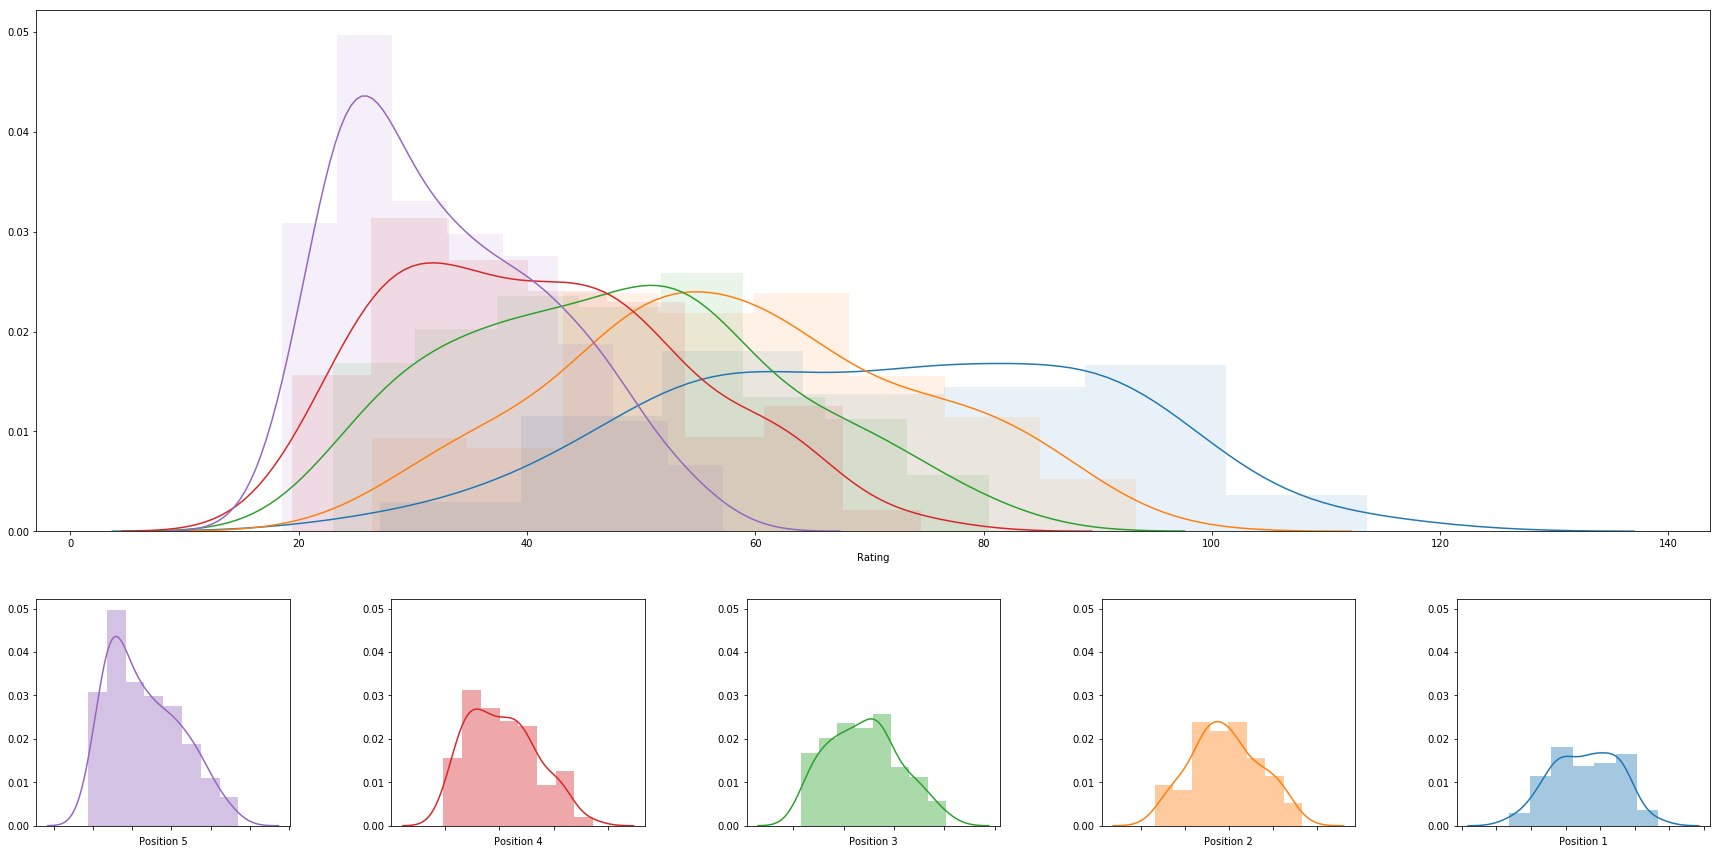

In [27]:
d = create_ratings_from_matches(df, [1.7, 1.2, .7, .45, .1])
rd = plot_rating_distribution(d['match_history'])
get_top_players(d['match_history'], position_='all').head(100).to_csv('2017___170_120_070_045_010.csv')

In [173]:
def get_prior_year_player_rating_adders(py_file, factor):
    df = pd.read_csv(py_file).drop_duplicates()
    df.columns = ['division', 'compID', 'location', 'date', 'college', 'first_name', 'last_name', 'position', 'result', 'score']
    
    d = create_ratings_from_matches(df, factor)
    df_top_players = get_top_players(d['match_history'], position_='all')

    #2 standard deviations from the mean - best performers
    two_sigma = 2*df_top_players.rating.std() + df_top_players.rating.mean()
    high_perfomers = df_top_players[df_top_players['rating'] > two_sigma][['name']]
    high_perfomers['adder'] = 2


    #3 standard deviations from the mean - over-performing outliers
    three_sigma = 3*df_top_players.rating.std() + df_top_players.rating.mean()
    ultra_high_perfomers = df_top_players[df_top_players['rating'] > three_sigma][['name']]
    ultra_high_perfomers['adder'] = 1

    adder = pd.concat([high_perfomers, ultra_high_perfomers])
    adder = adder.groupby(['name'])['adder'].sum().to_frame().sort_values(['adder'], ascending=False)
    adder_dict = adder.to_dict().values()[0]
    return adder_dict
adder_dict = get_prior_year_player_rating_adders('Data/Competition-2017.csv', [1.7, 1.2, .7, .45, .1])


{'Adlee Van Winden': 2,
 'Adrianna Culbert': 2,
 'Allie Wheeler': 2,
 'Bianca Arellano': 2,
 'Brooke Kuhlman': 2,
 'Chelsea Ross': 2,
 'Claire Coppola': 2,
 'Crissy Jones': 2,
 'Delaney Knudsen': 2,
 'Emily Sonny': 2,
 'Federica Frasca': 2,
 'Hannah Hubbard': 2,
 'Jessalyn Kinlaw': 2,
 'Kelly Claes': 3,
 'Kristen Nuss': 2,
 'Leigh Andrew': 2,
 'Lindsey Knudsen': 2,
 'Madalyn Roh': 2,
 'Madison Witt': 2,
 'Margherita Bianchin': 2,
 'Mckenna Witt': 2,
 'Megan McNamara': 2,
 'Mikayla Tucker': 2,
 'Morgan Martin': 2,
 'Nele Barber': 2,
 'Nicole McNamara': 2,
 'Payton Rund': 2,
 'Rachel Nieto': 2,
 'Sara Hughes': 3,
 'Sarah Sponcil': 2,
 'Savannah Slattery': 2,
 'Tia Scambray': 2,
 'Vanessa Freire': 2,
 'Whitney Follette': 2}

In [206]:
def create_start_rating(_adder_dict, _df_top_players):
    df_adder= pd.DataFrame.from_dict(_adder_dict, orient='index', columns=['adder']).reset_index()
    df_adder.columns = ['name', 'adder']
    df_starting_rating = pd.merge(_df_top_players, df_adder, how='outer')
    df_starting_rating['adder'] = df_starting_rating['adder'].fillna(0)
    df_starting_rating['start_rating'] = df_starting_rating['adder']+25
    df_starting_rating.columns = ['rank', 'name', 'college', 'division', 'last_season_end_rating',
       'primary position', 'date', 'adder', 'new_season_start_rating']
    return df_starting_rating[['name', 'college', 'division', 'last_season_end_rating','new_season_start_rating']]

create_start_rating(adder_dict, df_top_players).head(50)

,name,college,division,last_season_end_rating,new_season_start_rating
0,Sara Hughes,USC,DI,113.566520,28.0
1,Kelly Claes,USC,DI,113.566520,28.0
2,Crissy Jones,Washington,DI,105.552926,27.0
3,Federica Frasca,FIU,DI,102.112744,27.0
4,Leigh Andrew,Florida State,DI,101.536825,27.0
5,Nicole McNamara,UCLA,DI,98.947623,27.0
6,Megan McNamara,UCLA,DI,97.577749,27.0
7,Savannah Slattery,LMU,DI,96.919343,27.0
8,Brooke Kuhlman,Florida State,DI,95.465719,27.0
9,Hannah Hubbard,Cal Poly SLO,DI,95.298440,27.0


48.47812727466056 19.450444447626484


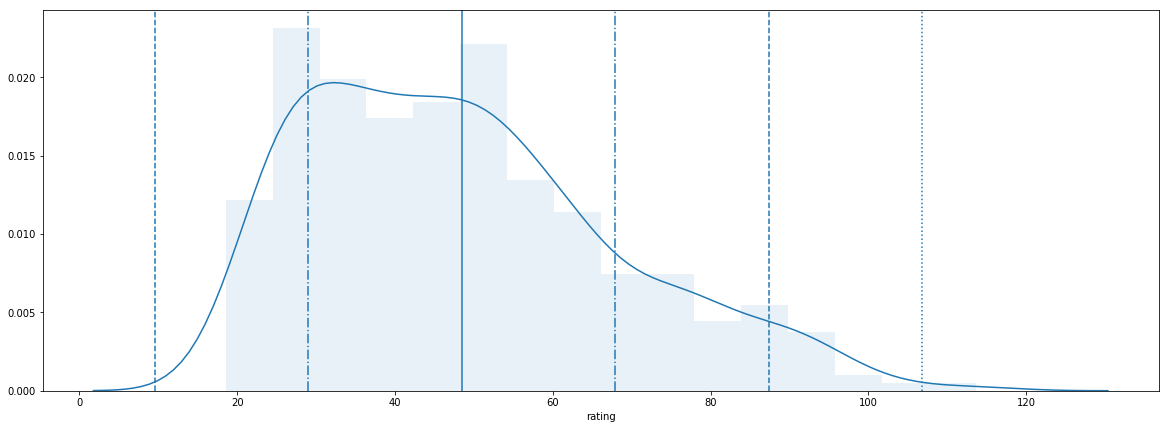

In [171]:
def plot_top_player_rating_distribution(df_):
    f =  plt.figure(figsize=(20, 7))
    sns.distplot( df_['rating'], hist_kws=dict(alpha=.1))
    #sns.lineplot( df_['rating'])
    print df_['rating'].mean(), df_['rating'].std()
    pyplot.axvline(x=df_['rating'].mean())
    pyplot.axvline(x=df_['rating'].mean()+ df_['rating'].std(), linestyle='-.')
    pyplot.axvline(x=df_['rating'].mean()- df_['rating'].std(), linestyle='-.')
    pyplot.axvline(x=df_['rating'].mean()+ 2*df_['rating'].std(), linestyle='--')
    pyplot.axvline(x=df_['rating'].mean()- 2*df_['rating'].std(), linestyle='--')
    pyplot.axvline(x=df_['rating'].mean()+ 3*df_['rating'].std(), linestyle=':')

    #sns.lmplot(x=, y=df_['rating'].max())
    return None #df_

plot_top_player_rating_distribution(df_top_players)



In [172]:
df_top_players

,rank,name,college,division,rating,primary position,date
0,1,Sara Hughes,USC,DI,113.566520,1,2017-05-07
1,2,Kelly Claes,USC,DI,113.566520,1,2017-05-07
2,3,Crissy Jones,Washington,DI,105.552926,1,2017-04-28
3,4,Federica Frasca,FIU,DI,102.112744,1,2017-04-23
4,5,Leigh Andrew,Florida State,DI,101.536825,1,2017-05-06
5,6,Nicole McNamara,UCLA,DI,98.947623,1,2017-04-28
6,7,Megan McNamara,UCLA,DI,97.577749,1,2017-04-28
7,8,Savannah Slattery,LMU,DI,96.919343,1,2017-04-22
8,9,Brooke Kuhlman,Florida State,DI,95.465719,1,2017-05-06
9,10,Hannah Hubbard,Cal Poly SLO,DI,95.298440,1,2017-04-29


# Enter the name of a player to get their rating history

In [ ]:
a = raw_input()
get_player_rating_history(d['match_history'], a).to_csv('Shannon Williams.csv')

# Matchups -  Probability of wins

### First get the probability of wins between two pairs

In [ ]:
import itertools
import math
BETA = 4.167

def win_probability(team1_, team2_):
    delta_mu = sum(r.mu for r in team1_) - sum(r.mu for r in team2_)
    sum_sigma = sum(r.sigma ** 2 for r in itertools.chain(team1_, team2_))
    size = len(team1_) + len(team2_)
    denom = math.sqrt(size * (BETA * BETA) + sum_sigma)
    ts = global_env()
    return ts.cdf(delta_mu / denom)

#matches = d['match_history']
#matches[(matches.compID == 800) & (matches.position == 1)]

In [ ]:
df['name'] = df.first_name + " " + df.last_name

In [ ]:

flight1 = ['Abril Bustamante','Tina Graudina','Megan McNamara','Nicole McNamara']
flight2 = df[(df.compID == 1873) & (df.position == 2)].sort_values(['position', 'college'])
flight2 = [a.strip() for a in flight2.name]

flight3 = df[(df.compID == 1873) & (df.position == 3)].sort_values(['position', 'college'])
flight3 = [a.strip() for a in flight3.name]
flight3

flight4 = df[(df.compID == 1873) & (df.position == 4)].sort_values(['position', 'college'])
flight4 = [a.strip() for a in flight4.name]
flight4

flight5 = df[(df.compID == 1873) & (df.position == 5)].sort_values(['position', 'college'])
flight5 = [a.strip() for a in flight5.name]
flight5

duel_dict = {1: flight1, 2: flight2, 3: flight3, 4:flight4, 5:flight5}
duel_dict.keys()
#predict_pair_matchup(d['match_history'], flight1), predict_pair_matchup(d['match_history'], flight3), predict_pair_matchup(d['match_history'], flight4), predict_pair_matchup(d['match_history'], flight5)

In [ ]:
def get_pair_matchup_probability(df, player_list):
    t1p1 = Rating(get_player_rating(df, player_list[0]))
    t1p2 = Rating(get_player_rating(df, player_list[1]))
    t2p1 = Rating(get_player_rating(df, player_list[2]))
    t2p2 = Rating(get_player_rating(df, player_list[3]))
    #print t1p1, t1p2, t2p1, t2p2
    print player_list[0], 'and', player_list[1], "have a", win_probability([t1p1,t1p2], [t2p1, t2p2])*100, \
        "% probability to win against", player_list[2], "and", player_list[3], "."
    return win_probability([t1p1,t1p2], [t2p1, t2p2])

def predict_pair_matchup(df,player_list):
    p = get_pair_matchup_probability(df, player_list)
    if p > .55:
        t1 = 1
        t2 = 0
    elif p < .45:
        t1 = 0
        t2 = 1
    else:
        t1 = 0
        t2 = 0
    return t1, t2

def get_duel_dict(df, team1, team2):
    duel_dict = {}
    for i in range(1,6):
        flight1_1 = list(df_top_players[(df_top_players.college == team1) & (df_top_players['primary position'] == i)][:2].name)
        flight1_2 = list(df_top_players[(df_top_players.college == team2) & (df_top_players['primary position'] == i)][:2].name)
        duel_dict[i] = flight1_1+flight1_2
    return duel_dict

def predict_duel_matchup(df, team1, team2):
    duel_dict = get_duel_dict(d['match_history'], team1, team2)
    t1 = 0
    t2 = 0
    for i in duel_dict.keys():
        temp_t = predict_pair_matchup(df, duel_dict[i])
        #print temp_t
        t1 += temp_t[0]
        t2 += temp_t[1]
    
    print "\n"
    
    if t1 > t2:
        print team1, "is predicted to win the duel", t1, "-", t2
    else:
        print team2, "is predicted to win the duel", t2, "-", t1
    
    return t1, t2

predict_duel_matchup(d['match_history'], 'South Carolina', 'Stanford') 

# Preseason Rankings - non senior players

Need team rosters

In [ ]:
    for idx, rows in match.iterrows():
        r = {}
        p_lookup = {}
        t = {}
        for i in range(1,5):
            p_lookup[i] = lookup_player_rating(rows.iloc[i],[rows.iloc[5], rows.iloc[6]], df_player_rating )
            r[i] = Rating(mu=p_lookup[i].mu, sigma=p_lookup[i].sigma)
    
        t[1] = [r[1], r[2]]
        t[2] = [r[3], r[4]]
        
        win_prob = win_probability(t[1], t[2])
    
        
        match.loc[idx, 'Probability'] = win_prob 
        #print win_prob
        if (win_prob >.60):
            match.loc[idx, 'Predicted Winner'] = p_lookup[1]['Team'] 
            match.loc[idx, 'Distance From Draw'] = (win_prob - .60)
            match.loc[idx, 'T1 Win'] = 1
        elif (win_prob <.40):
            match.loc[idx, 'Predicted Winner'] = p_lookup[3]['Team'] 
            match.loc[idx, 'Distance From Draw'] = (.40-win_prob )
            match.loc[idx, 'T1 Win'] = 0
        else:
            match.loc[idx, 'Predicted Winner'] = 'Draw'
            match.loc[idx, 'Distance From Draw'] = 0
            match.loc[idx, 'T1 Win'] = .5

In [ ]:




    groups = df_matches.groupby(['date', 'compID', 'position']).groups
    counter = 0
    hist_dict = {}

    for key, value in sorted(groups.iteritems()):
        r = {}
        r_new = {}
        
        for i in range(len(value)):
            fname = df_matches.iloc[value[i], df_matches.columns.get_loc('first_name')]
            lname = df_matches.iloc[value[i], df_matches.columns.get_loc('last_name')]
            college = df_matches.iloc[value[i], df_matches.columns.get_loc('college')]
            position = df_matches.iloc[value[i], df_matches.columns.get_loc('position')]
            r[i] = get_player_ratings_from_match(df_players, fname, lname, college)

        t1 = [r[0], r[1]]
        t2 = [r[2], r[3]]

        ((r_new[0], r_new[1]), (r_new[2], r_new[3])) = rate([t1,t2], ranks=[1,0])

        for j in range(4):
            fname = df_matches.iloc[value[j], df_matches.columns.get_loc('first_name')]
            lname = df_matches.iloc[value[j], df_matches.columns.get_loc('last_name')]
            college = df_matches.iloc[value[j], df_matches.columns.get_loc('college')]
            position = df_matches.iloc[value[j], df_matches.columns.get_loc('position')]
            set_player_ratings_after_match(df_players, \
                                           fname, \
                                           lname, \
                                           college, \
                                           position, \
                                           k_factor_, \
                                           Rating(mu=(r_new[j].mu +k_factor_[i]), sigma=r_new[j].sigma  )) 

In [ ]:


def actual_match(compid_, df_):
    return df_[df_['Compid'].astype(int) == compid_].groupby('Winner')['Position'].count()

actual_match(1863, df_matchups)

def predict_match(compid, df):
    match = df[df['Compid'].astype(int) == compid].copy().reset_index().iloc[:,1:]
    for idx, rows in match.iterrows():
        r = {}
        p_lookup = {}
        t = {}
        for i in range(1,5):
            p_lookup[i] = lookup_player_rating(rows.iloc[i],[rows.iloc[5], rows.iloc[6]], df_player_rating )
            r[i] = Rating(mu=p_lookup[i].mu, sigma=p_lookup[i].sigma)
            #match[i] = r[i]
    
        t[1] = [r[1], r[2]]
        t[2] = [r[3], r[4]]
        
        win_prob = win_probability(t[1], t[2])
    
        
        match.loc[idx, 'Probability'] = win_prob 
        #print win_prob
        if (win_prob >.60):
            match.loc[idx, 'Predicted Winner'] = p_lookup[1]['Team'] 
            match.loc[idx, 'Distance From Draw'] = (win_prob - .60)
            match.loc[idx, 'T1 Win'] = 1
        elif (win_prob <.40):
            match.loc[idx, 'Predicted Winner'] = p_lookup[3]['Team'] 
            match.loc[idx, 'Distance From Draw'] = (.40-win_prob )
            match.loc[idx, 'T1 Win'] = 0
        else:
            match.loc[idx, 'Predicted Winner'] = 'Draw'
            match.loc[idx, 'Distance From Draw'] = 0
            match.loc[idx, 'T1 Win'] = .5
        
    
    return match

_df = {}
temp = None
for a in range(780, 1870):
    print a,
    _df = predict_match(a, df_matchups)
    _df = pd.concat([_df, temp], axis=0)
    temp = _df


total_no_draw = len(_df[_df['Winner'] != 'Draw'])
accurate = len(_df[_df['Winner'] == _df['Predicted Winner']])
print accurate, total_no_draw, accurate*100/total_no_draw

_df



In [ ]:
# Predict a Match

ef predictMatch(_compid, _df):
    _match = df_all_matchups[df_all_matchups['CompID'] == _compid].iloc[:,0:5]
    wins = {}

    for i in range(0,len(_match)):
        r = [Rating(lookupPlayerRating(_match.iloc[i,j], predict_ranking))  for j in range(1,5)]

        t1 = [r[0], r[1]]
        t2 = [r[2], r[3]]

        win_prob = win_probability(t1, t2)

        #print [(_match.iloc[i,j]+"("+lookupPlayer(_match.iloc[i,j], _df)['Team']+")") for j in range(1,5) ],

        if win_prob > .50:
            val = max(lookupPlayer(_match.iloc[i, 1], _df)['Team'], lookupPlayer(_match.iloc[i, 2], _df)['Team'])
            #print val, ' favored'
            try:
                wins[val] += 1
            except:
                wins[val] =  1
        elif win_prob < .50:
            val = max(lookupPlayer(_match.iloc[i, 3], _df)['Team'], lookupPlayer(_match.iloc[i, 4], _df)['Team'])
            #print val, ' favored'
            try:
                wins[val] += 1
            except:
                wins[val] =  1
        else:
            val = 'Draw'
            try:
                wins[val] += 1
            except:
                wins[val] =  1
                
    match_winner = max(wins.iteritems(), key=operator.itemgetter(1))[0]      
    
    return wins, match_winner

print "Predicted:" + str(predictMatch(1816, df_player_ratings))
print "Actual:" + str(actualMatch(1816, df_player_ratings))